In [1]:
import datasets
import plotly.graph_objects as go
import numpy as np
import torch
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

### Preprocessing functions

In [2]:
wsd = datasets.load_dataset('clarin-knext/wsd_polish_datasets')

In [3]:
def tokenize(texts, tokenizer):
    return tokenizer(
        texts['text'], 
        padding='max_length', 
        truncation=True, 
        max_length=512, 
        return_tensors="pt"
    )

In [4]:
def get_first_noun(batch):
    target_word = []
    target_word_id = []

    for token in batch['tokens']:
        for i, (pos, word) in enumerate(zip(token['pos'], token['lemma'])):
            if pos == 'noun':
                target_word.append(word)
                target_word_id.append(i)
                break
        else:
            target_word.append(None)
            target_word_id.append(None)
    
    return {'target_word': target_word, 'target_word_id': target_word_id}

In [5]:
def extract_representations(batch, model):
    with torch.no_grad():
        outputs = model(
            input_ids=batch['input_ids'].to(model.device), 
            attention_mask=batch['attention_mask'].to(model.device),
            output_hidden_states=True
        )
    
    embeddings = {
        'embeddings_l1': [],
        'embeddings_l2': [],
        'embeddings_l11': [],
        'embeddings_l12': [],
    }

    for i, (word, word_id) in enumerate(zip(batch['target_word'], batch['target_word_id'])):
        if word is None:
            for key in embeddings.keys():
                embeddings[key].append(None)
        else:
            word_id = word_id.int()
            embeddings['embeddings_l1'].append(outputs.hidden_states[1][i, word_id, :].cpu().numpy())
            embeddings['embeddings_l2'].append(outputs.hidden_states[2][i, word_id, :].cpu().numpy())
            embeddings['embeddings_l11'].append(outputs.hidden_states[-2][i, word_id, :].cpu().numpy())
            embeddings['embeddings_l12'].append(outputs.hidden_states[-1][i, word_id, :].cpu().numpy())

    return embeddings

In [6]:
wsd = wsd['train']
wsd = wsd.map(get_first_noun, batched=True)

Map:   0%|          | 0/7848 [00:00<?, ? examples/s]

In [7]:
target_words = Counter(wsd['target_word'])
target_words.most_common()

[('to', 187),
 ('czas', 88),
 ('człowiek', 87),
 ('dzień', 83),
 ('rok', 69),
 ('raz', 43),
 ('Pan', 42),
 ('CO', 37),
 ('co', 32),
 ('dziecko', 28),
 ('koniec', 26),
 ('pan', 25),
 ('wszystko', 25),
 ('część', 24),
 ('sprawa', 24),
 ('ktoś', 24),
 ('coś', 23),
 ('głowa', 22),
 ('związek', 22),
 ('chwila', 21),
 ('praca', 21),
 ('nic', 20),
 ('kto', 19),
 ('droga', 19),
 ('głos', 19),
 ('Polska', 18),
 ('język', 18),
 ('jednostka', 18),
 ('przykład', 18),
 ('proces', 18),
 ('cel', 17),
 ('osoba', 17),
 ('system', 17),
 ('sposób', 17),
 ('ręka', 17),
 ('dziennik', 17),
 ('pani', 16),
 ('strona', 16),
 ('sytuacja', 16),
 ('informacja', 16),
 ('spotkanie', 16),
 ('rodzaj', 16),
 ('kobieta', 15),
 ('słowo', 15),
 ('poseł', 15),
 ('okres', 15),
 ('początek', 14),
 ('badanie', 14),
 ('forma', 14),
 ('program', 14),
 ('wszyscy', 13),
 ('grupa', 13),
 ('tydzień', 13),
 ('problem', 13),
 ('książka', 13),
 ('podstawa', 13),
 ('metoda', 13),
 ('nazwa', 13),
 ('większość', 12),
 ('policjant', 12),

## Bert

### Model Init

In [6]:
bert_model = AutoModel.from_pretrained('allegro/herbert-base-cased')
bert_tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')

/home/bartek/SZT/Sem2/venv/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initiali

In [7]:
_ = bert_model.eval().to('cuda')

### Data Preparation

In [ ]:
bert_wsd_data = wsd.map(lambda x: tokenize(x, bert_tokenizer), batched=True)
bert_wsd_data.set_format(type='torch', columns=['input_ids', 'attention_mask'])

In [ ]:
bert_wsd_data = bert_wsd_data.map(lambda x: extract_representations(x, bert_model), batched=True, batch_size=100)

In [ ]:
bert_wsd_data, wsd

(Dataset({
     features: ['text', 'tokens', 'phrases', 'wsd', 'input_ids', 'token_type_ids', 'attention_mask', 'target_word', 'target_word_id', 'embeddings_l1', 'embeddings_l2', 'embeddings_l11', 'embeddings_l12'],
     num_rows: 7848
 }),
 Dataset({
     features: ['text', 'tokens', 'phrases', 'wsd'],
     num_rows: 7848
 }))

In [64]:
bert_wsd_data[0]['embeddings_l2'].shape

torch.Size([768])

### Anisotropy Analysis

In [65]:
target_words = target_words.most_common(5)
target_words

[('to', 187), ('czas', 88), ('człowiek', 87), ('dzień', 83), ('rok', 69)]

In [66]:
bert_word_embeddings = {
    word: {
        'embeddings_l1': [],
        'embeddings_l2': [],
        'embeddings_l11': [],
        'embeddings_l12': [],
    } for word, _ in target_words
}

for bert_data in bert_wsd_data:
    if bert_data['target_word'] not in bert_word_embeddings:
        continue

    for key in bert_word_embeddings[bert_data['target_word']].keys():
        bert_word_embeddings[bert_data['target_word']][key].append(bert_data[key])

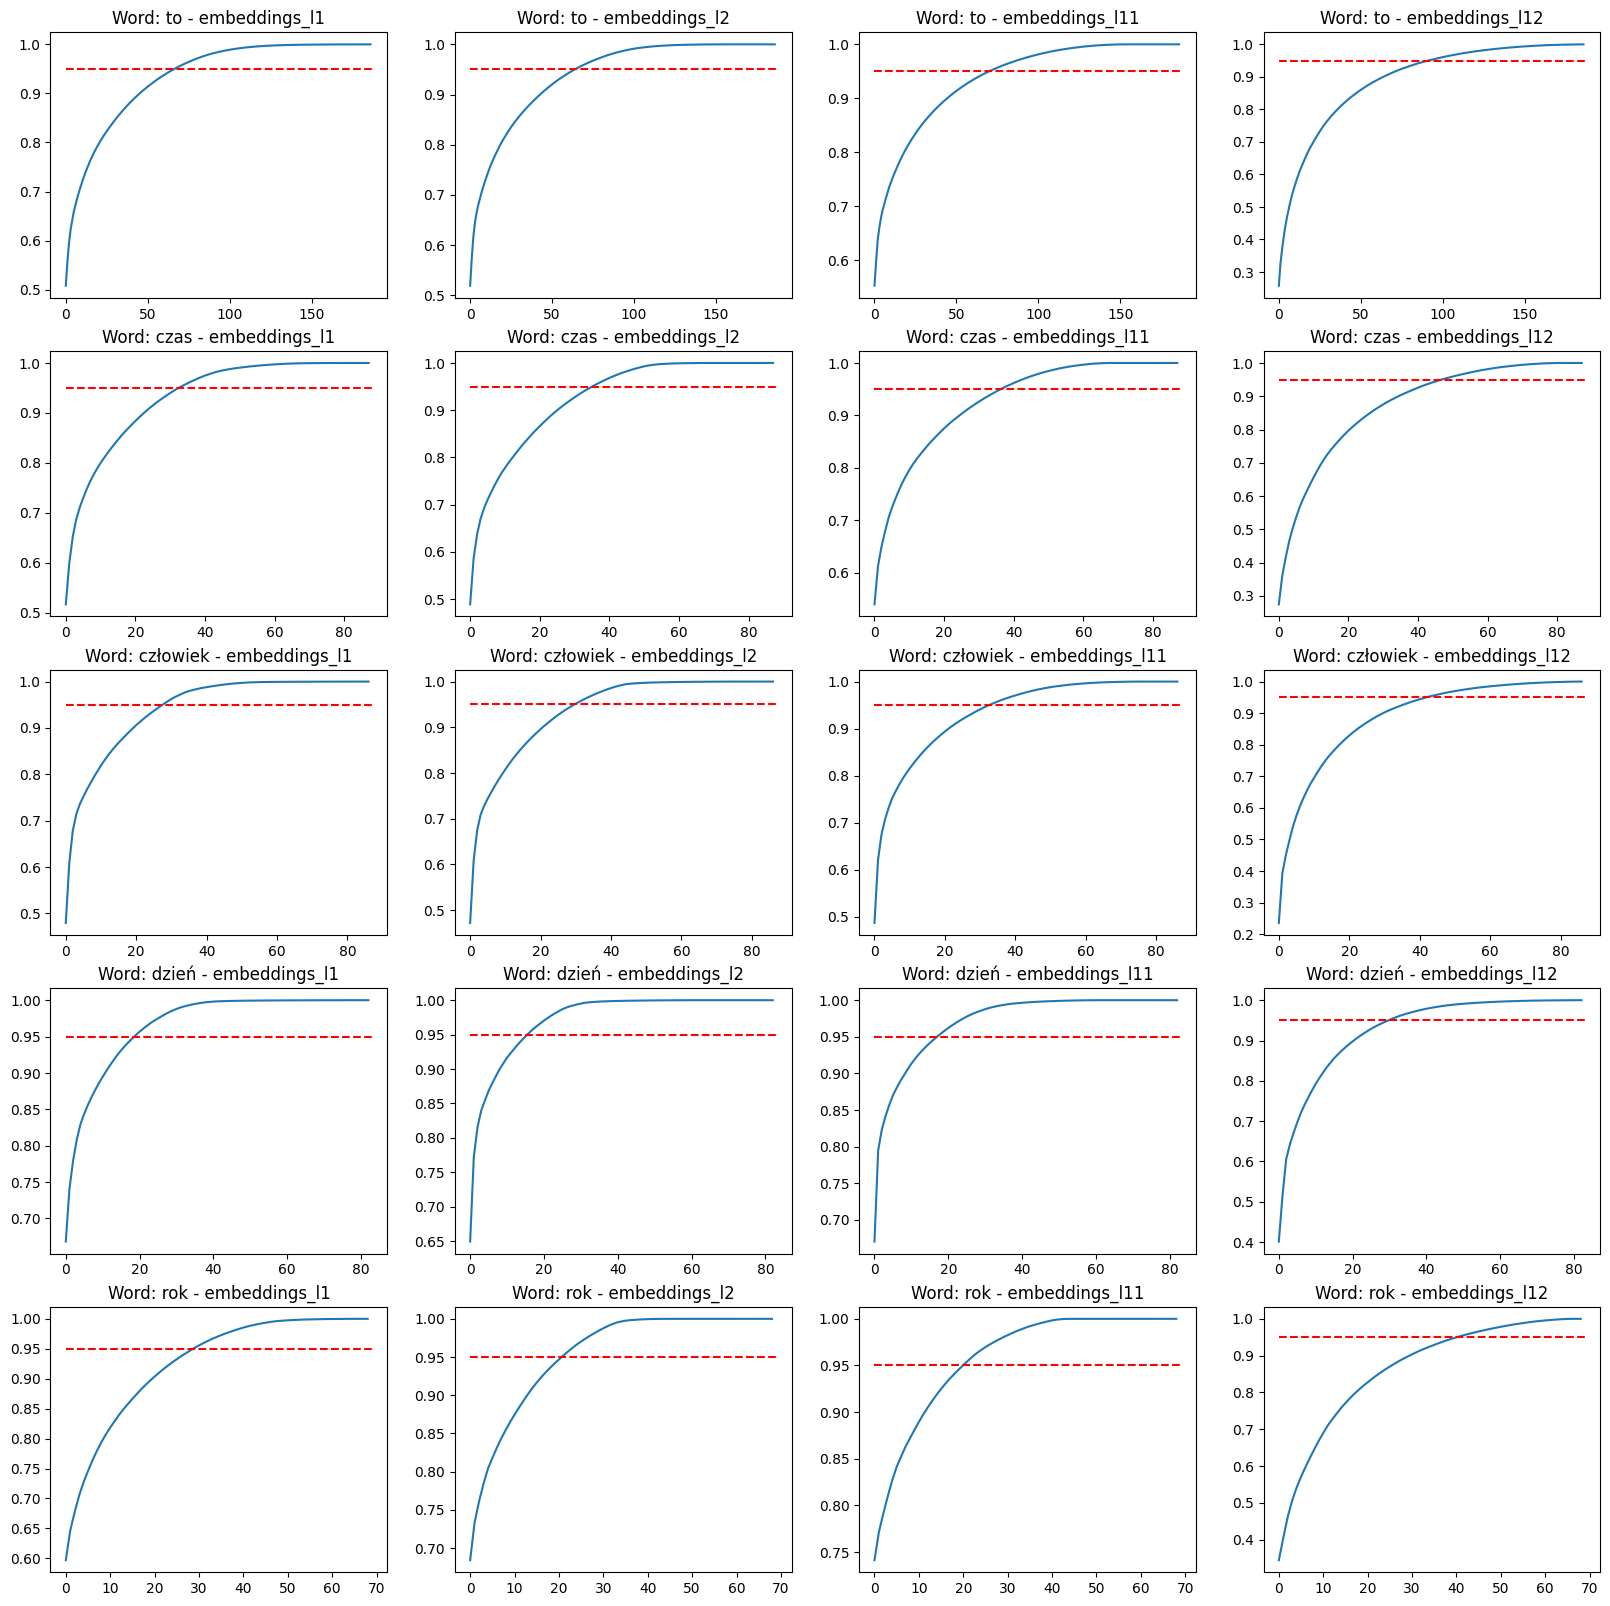

In [ ]:
_, axs = plt.subplots(5, 4, figsize=(16, 20))

for i, (word, _) in enumerate(target_words):
    for j, key in enumerate(bert_word_embeddings[word].keys()):
        pca = PCA()
        pca_embeddings = pca.fit(torch.stack(bert_word_embeddings[word][key]).cpu().numpy())

        axs[i, j].plot(np.cumsum(pca.explained_variance_ratio_))
        axs[i, j].hlines(0.95, 0, pca.explained_variance_ratio_.shape[0], color='red', linestyles='dashed')
        axs[i, j].set_title(f'Word: {word} - {key}')

plt.show()

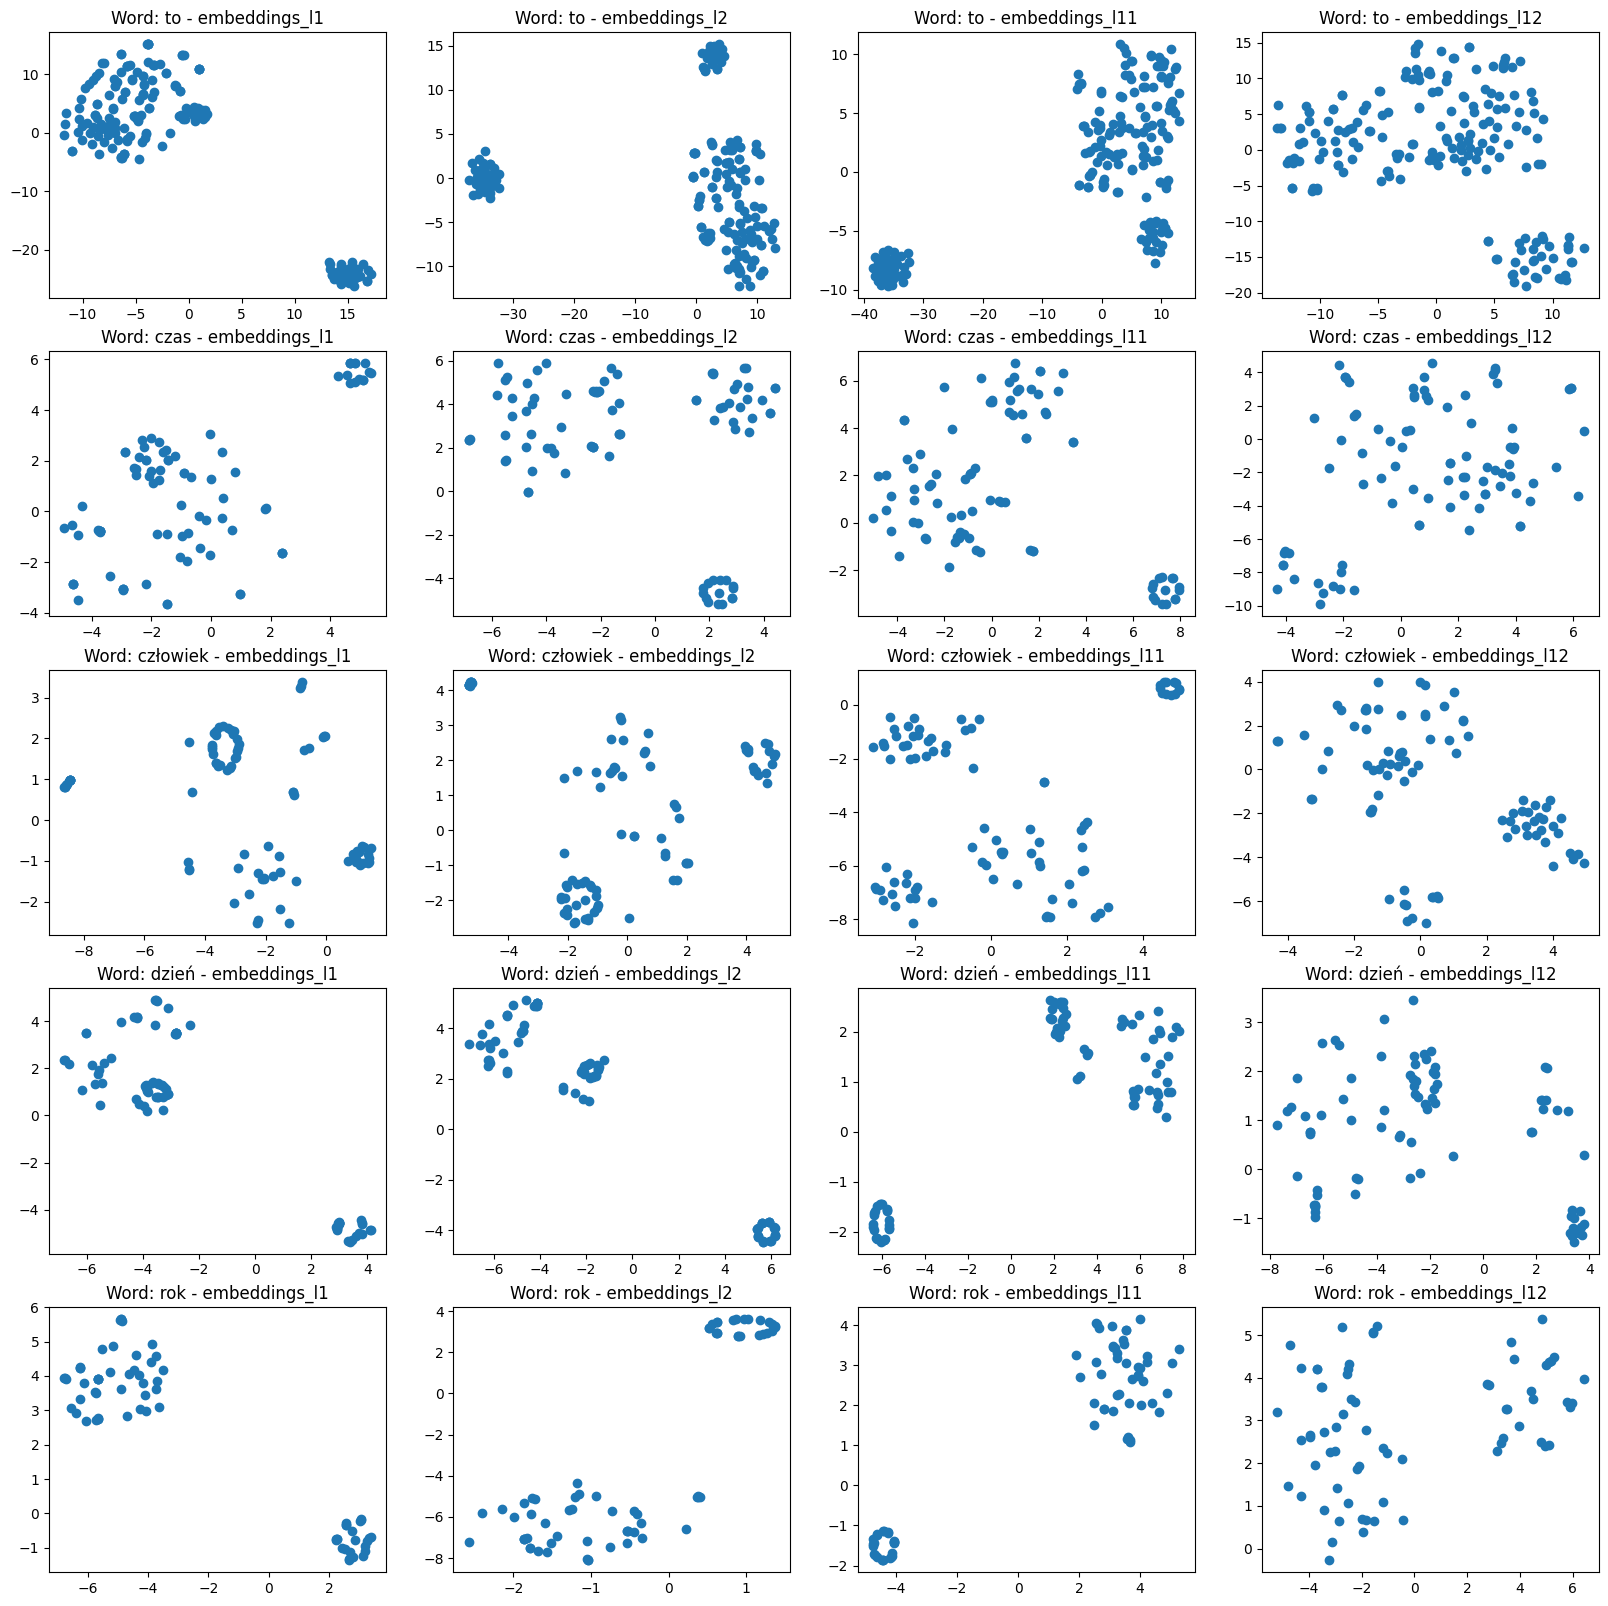

In [ ]:
_, axs = plt.subplots(5, 4, figsize=(16, 20))

for i, (word, _) in enumerate(target_words):
    for j, key in enumerate(bert_word_embeddings[word].keys()):
        tsne = TSNE(n_components=2)
        tsne_embeddings = tsne.fit_transform(torch.stack(bert_word_embeddings[word][key]).cpu().numpy())

        axs[i, j].scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1])
        axs[i, j].set_title(f'Word: {word} - {key}')

plt.show()

### Context-Specificity Analysis

In [74]:
average_embeddings = {
    word: {
        emb: np.mean(np.stack(bert_word_embeddings[word][emb]), axis=0)
        for emb in bert_word_embeddings[word].keys()
    } for word, _ in target_words
}

In [76]:
average_embeddings['to']['embeddings_l1'].shape

(768,)

In [79]:
similarities = {
    word: {
        emb: [
            cosine_similarity(
                average_embeddings[word][emb].reshape(1, -1), 
                embedding.reshape(1, -1)
            )[0][0]
            for embedding in bert_word_embeddings[word][emb]
        ]
        for emb in average_embeddings[word].keys()
    } for word, _ in target_words
}

In [81]:
context_specifity = {
    word: {
        emb: (np.mean(similarities[word][emb]), np.std(similarities[word][emb]))
        for emb in similarities[word].keys()
    } for word, _ in target_words
}

In [97]:
fig = go.Figure()

for word, _ in target_words:
    fig.add_trace(go.Scatter(
        x=list(context_specifity[word].keys()),
        y=[x[0] for x in context_specifity[word].values()],
        error_y=dict(type='data', array=[x[1] for x in context_specifity[word].values()]),
        mode='lines+markers',
        name=word
    ))

fig.update_layout(
    title='Context-Specificity Analysis',
    xaxis_title='Embedding Layer',
    yaxis_title='Context-Specificity',
    xaxis=dict(tickangle=45),
    yaxis=dict(range=[0.25, 1.1])
)

fig.show()

## GPT2

### Model Init

In [8]:
gpt_model = AutoModel.from_pretrained('sdadas/polish-gpt2-small')
gpt_tokenizer = AutoTokenizer.from_pretrained('sdadas/polish-gpt2-small')
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token
gpt_model.config.pad_token_id = gpt_tokenizer.eos_token_id

In [9]:
_ = gpt_model.eval().to('cuda')

### Data Preparation

In [10]:
gpt2_wsd_data = wsd.map(lambda x: tokenize(x, gpt_tokenizer), batched=True)
gpt2_wsd_data.set_format(type='torch', columns=['input_ids', 'attention_mask'])

Map:   0%|          | 0/7848 [00:00<?, ? examples/s]

In [13]:
gpt2_wsd_data = gpt2_wsd_data.map(lambda x: extract_representations(x, gpt_model), batched=True, batch_size=100)

Map:   0%|          | 0/7848 [00:00<?, ? examples/s]

In [19]:
gpt2_wsd_data, wsd

(Dataset({
     features: ['text', 'tokens', 'phrases', 'wsd', 'target_word', 'target_word_id', 'input_ids', 'attention_mask', 'embeddings_l1', 'embeddings_l2', 'embeddings_l11', 'embeddings_l12'],
     num_rows: 7848
 }),
 Dataset({
     features: ['text', 'tokens', 'phrases', 'wsd', 'target_word', 'target_word_id'],
     num_rows: 7848
 }))

### Anisotropy Analysis

In [17]:
target_words = target_words.most_common(5)
target_words

[('to', 187), ('czas', 88), ('człowiek', 87), ('dzień', 83), ('rok', 69)]

In [24]:
gpt_word_embeddings = {
    word: {
        'embeddings_l1': [],
        'embeddings_l2': [],
        'embeddings_l11': [],
        'embeddings_l12': [],
    } for word, _ in target_words
}

for gpt_data, wsd_data in zip(gpt2_wsd_data, wsd):
    if wsd_data['target_word'] not in gpt_word_embeddings:
        continue

    for key in gpt_word_embeddings[wsd_data['target_word']].keys():
        gpt_word_embeddings[wsd_data['target_word']][key].append(gpt_data[key])

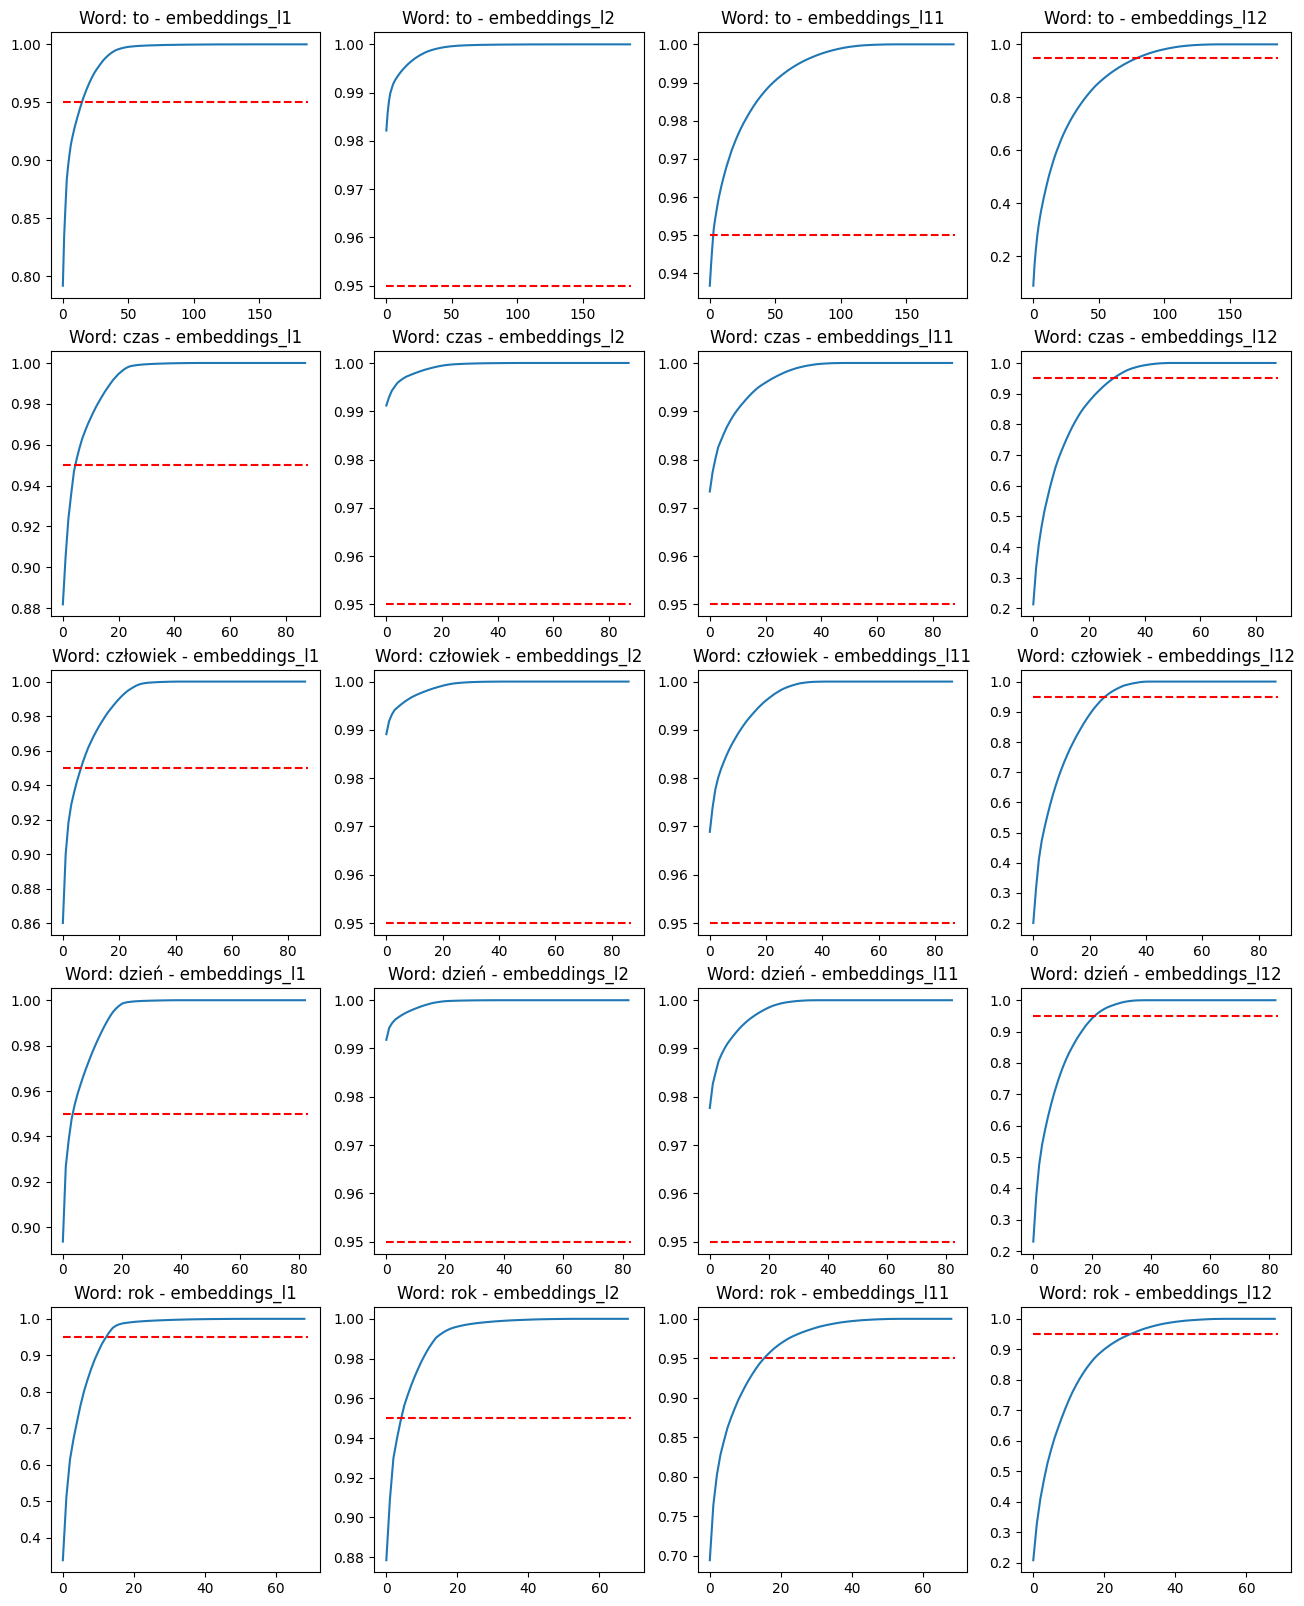

In [32]:
_, axs = plt.subplots(5, 4, figsize=(16, 20))

for i, (word, _) in enumerate(target_words):
    for j, key in enumerate(gpt_word_embeddings[word].keys()):
        pca = PCA()
        pca_embeddings = pca.fit(torch.stack(gpt_word_embeddings[word][key]).cpu().numpy())

        axs[i, j].plot(np.cumsum(pca.explained_variance_ratio_))
        axs[i, j].hlines(0.95, 0, pca.explained_variance_ratio_.shape[0], color='red', linestyles='dashed')
        axs[i, j].set_title(f'Word: {word} - {key}')

plt.show()

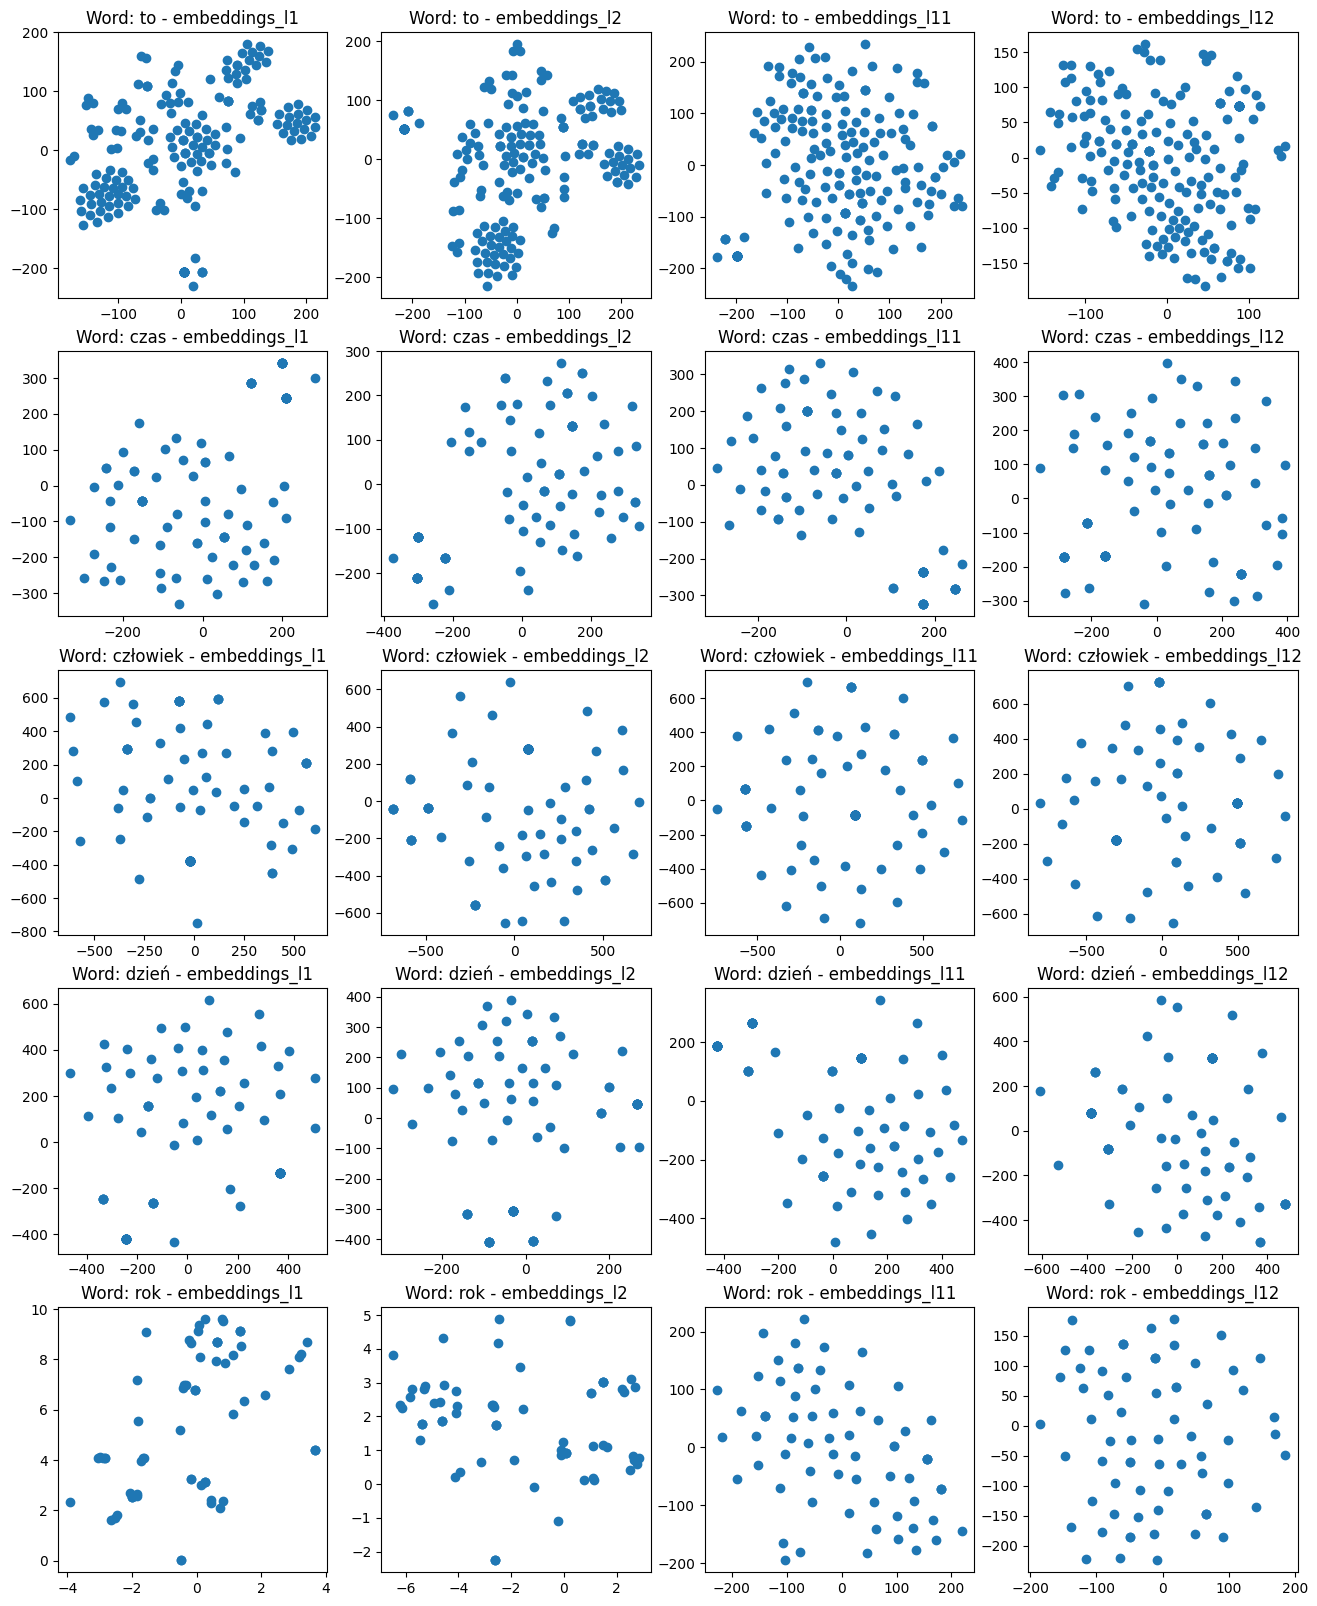

In [33]:
_, axs = plt.subplots(5, 4, figsize=(16, 20))

for i, (word, _) in enumerate(target_words):
    for j, key in enumerate(gpt_word_embeddings[word].keys()):
        tsne = TSNE(n_components=2)
        tsne_embeddings = tsne.fit_transform(torch.stack(gpt_word_embeddings[word][key]).cpu().numpy())

        axs[i, j].scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1])
        axs[i, j].set_title(f'Word: {word} - {key}')

plt.show()

### Context-Specificity Analysis

In [27]:
average_embeddings = {
    word: {
        emb: np.mean(np.stack(gpt_word_embeddings[word][emb]), axis=0)
        for emb in gpt_word_embeddings[word].keys()
    } for word, _ in target_words
}

In [28]:
average_embeddings['to']['embeddings_l1'].shape

(768,)

In [29]:
similarities = {
    word: {
        emb: [
            cosine_similarity(
                average_embeddings[word][emb].reshape(1, -1), 
                embedding.reshape(1, -1)
            )[0][0]
            for embedding in gpt_word_embeddings[word][emb]
        ]
        for emb in average_embeddings[word].keys()
    } for word, _ in target_words
}

In [30]:
context_specifity = {
    word: {
        emb: (np.mean(similarities[word][emb]), np.std(similarities[word][emb]))
        for emb in similarities[word].keys()
    } for word, _ in target_words
}

In [31]:
fig = go.Figure()

for word, _ in target_words:
    fig.add_trace(go.Scatter(
        x=list(context_specifity[word].keys()),
        y=[x[0] for x in context_specifity[word].values()],
        error_y=dict(type='data', array=[x[1] for x in context_specifity[word].values()]),
        mode='lines+markers',
        name=word
    ))

fig.update_layout(
    title='Context-Specificity Analysis',
    xaxis_title='Embedding Layer',
    yaxis_title='Context-Specificity',
    xaxis=dict(tickangle=45),
    yaxis=dict(range=[0.25, 1.1])
)

fig.show()